<a href="https://colab.research.google.com/github/nikizadehgfdl/thin-wall-topography/blob/colab/python/algorithm_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook is for developement and testing of algorithm for the thin wall topography

## 3.1 Fine grid generation and interpolation

### Create test grids

Some helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Helper functions

def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r',alpha=1.0):
    #mesh plot
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color, alpha=alpha)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color, alpha=alpha)

def generate_rect_test_grid(lons,lone,ni,lats,late,nj):
    #generate a simple rectilinear grid
    lon = lons + np.arange(ni+1) * (lone-lons)/ni
    lat = lats + np.arange(nj+1) * (late-lats)/nj
    lon_grid = np.tile(lon, (nj+1,1)) 
    lat_grid = np.tile(lat.reshape(nj+1,1), (1,ni+1))
    return lon_grid,lat_grid

Actual source data like GEBCO (below) are too large for devloping/tesing. Here we use simple small recitilinear grids to sart

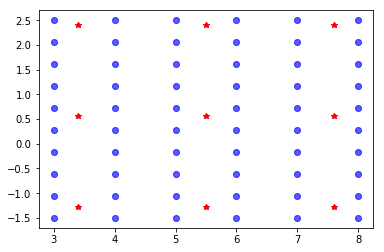

In [2]:
#Let's start with some small rectilinear grids for testing
#source grid 
src_lon_grid,src_lat_grid = generate_rect_test_grid(lons=3,lone=8,ni=5,lats=-1.5,late=2.5,nj=9)
#target grid
trg_lon_grid,trg_lat_grid = generate_rect_test_grid(3.4,7.6,2,-1.28,2.4,2)
plot_mesh_in_latlon(src_lon_grid, src_lat_grid, phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(trg_lon_grid, trg_lat_grid, phi_color='r*', lam_color='r*')

### GridMesh Class

In [56]:
import numpy as np

def is_source_uniform(xs,ys):
    """Returns True if the input grid is uniform and False otherwise"""
    delx = np.roll(xs,shift=-1, axis=1) - xs 
    delx = delx[:,:-1]
    dely = np.roll(ys,shift=-1, axis=0) - ys 
    dely = dely[:-1,:]
    return (np.all(np.isclose(delx, delx[0,0]))) and (np.all(np.isclose(dely, dely[0,0])))


class GMesh:
    """Describes 2D meshes for ESMs.
    
    Meshes have shape=(nj,ni) cells with (nj+1,ni+1) vertices with coordinates (x,y).
    
    When constructing, either provide 1d or 2d coordinates (x,y), or assume a
    uniform spherical grid with 'shape' cells covering the whole sphere with
    longitudes starting at x0.
    
    Attributes:
    
    shape - (nj,ni)
    ni    - number of cells in x-direction (last)
    nj    - number of cells in y-direction (first)
    x     - longitude of mesh (cell corners), shape (nj+1,ni=1)
    y     - latitude of mesh (cell corners), shape (nj+1,ni=1)
    area  - area of cells, shape (nj,ni)
    """

    def __init__(self, shape=None, x=None, y=None, area=None, x0=-180.):
        """Constructor for Mesh:
        shape - shape of cell array, (nj,ni)
        ni    - number of cells in x-direction (last index)
        nj    - number of cells in y-direction (first index)
        x     - longitude of mesh (cell corners) (1d or 2d)
        y     - latitude of mesh (cell corners) (1d or 2d)
        area  - area of cells (2d)
        x0    - used when generating a spherical grid in absence of (x,y)
        """
        if (shape is None) and (x is None) and (y is None): raise Exception('Either shape must be specified or both x and y')
        if (x is None) and (y is not None): raise Exception('Either shape must be specified or both x and y')
        if (x is not None) and (y is None): raise Exception('Either shape must be specified or both x and y')
        # Determine shape
        if shape is not None:
            (nj,ni) = shape
        else: # Determine shape from x and y
            if (x is None) or (y is None): raise Exception('Either shape must be specified or both x and y')
            if len(x.shape)==1: ni = x.shape[0]-1
            elif len(x.shape)==2: ni = x.shape[1]-1
            else: raise Exception('x must be 1D or 2D.')
            if len(y.shape)==1 or len(y.shape)==2: nj = y.shape[0]-1
            else: raise Exception('y must be 1D or 2D.')
        self.ni = ni
        self.nj = nj
        self.shape = (nj,ni)
        # Check shape of arrays and construct 2d coordinates
        if x is not None and y is not None:
            if len(x.shape)==1:
                if len(y.shape)>1: raise Exception('x and y must either be both 1d or both 2d')
                if x.shape[0] != ni+1: raise Exception('x has the wrong length')
            if len(y.shape)==1:
                if len(x.shape)>1: raise Exception('x and y must either be both 1d or both 2d')
                if y.shape[0] != nj+1: raise Exception('y has the wrong length')
            if len(x.shape)==2 and len(y.shape)==2:
                if x.shape != y.shape: raise Exception('x and y are 2d and must be the same size')
                if x.shape != (nj+1,ni+1): raise Exception('x has the wrong size')
                self.x = x
                self.y = y
            else:
                self.x, self.y = np.meshgrid(x,y)
        else: # Construct coordinates
            y1d = np.linspace(-90.,90.,nj+1)
            x1d = np.linspace(x0,x0+360.,ni+1)
            self.x, self.y = np.meshgrid(x1d,y1d)
        if area is not None:
            if area.shape != (nj,ni): raise Exception('area has the wrong shape or size')
            self.area = area
        else:
            self.area = None
    def __repr__(self):
        return '<GMesh ni:%i nj:%i shape:(%i,%i)>'%(self.ni,self.nj,self.shape[0],self.shape[1])
    def __getitem__(self, key):
        return getattr(self, key)

    def dump(self):
        print(self)
        print('x =',self.x)
        print('y =',self.y)
        print('area =',self.area)
    def refineby2(self):
        """Returns new Mesh instance with twice the resolution"""
        x = np.zeros( (2*self.nj+1, 2*self.ni+1) )
        y = np.zeros( (2*self.nj+1, 2*self.ni+1) )
        #area = numpy.zeros( (2*self.nj, 2*self.ni) )
        x[::2,::2] = self.x
        x[::2,1::2] = 0.5 * ( self.x[:,:-1] + self.x[:,1:] )
        x[1::2,::2] = 0.5 * ( self.x[:-1,:] + self.x[1:,:] )
        x[1::2,1::2] = 0.25 * ( ( self.x[:-1,:-1] + self.x[1:,1:] ) + ( self.x[:-1,1:] + self.x[1:,:-1] ) )
        y[::2,::2] = self.y
        y[::2,1::2] = 0.5 * ( self.y[:,:-1] + self.y[:,1:] )
        y[1::2,::2] = 0.5 * ( self.y[:-1,:] + self.y[1:,:] )
        y[1::2,1::2] = 0.25 * ( ( self.y[:-1,:-1] + self.y[1:,1:] ) + ( self.y[:-1,1:] + self.y[1:,:-1] ) )
        return GMesh(x=x, y=y)
        
    def find_nn_uniform_source(self,xs,ys):
        """Returns the i&j arrays for the indexes of the nearest neighbor point to each mesh point"""
        #Here we assume that the source mesh {(xs,ys)} is a uniform lat-lon mesh!
        #In this case the index of the closest source point can be easily found by arithmetic.          
        if (not is_source_uniform(xs,ys)): raise Exception('source grid is not uniform, this method will not work properly')
        delxs = xs[0,1] - xs[0,0]
        delys = ys[1,0] - ys[0,0]        
#        nn_i = np.rint((self.x-xs[0,0])/delxs) #Nearest integer (the even one if equidistant)
#        nn_j = np.rint((self.y-ys[0,0])/delys)   
        nn_i = np.floor(0.5+(self.x-xs[0,0])/delxs) #Nearest integer (the upper one if equidistant)
        nn_j = np.floor(0.5+(self.y-ys[0,0])/delys)  
        #These must be bounded by the extents of the arrays
        upper_i=xs.shape[1]-1
        upper_j=ys.shape[0]-1
        nn_i = np.where(nn_i>upper_i, upper_i, nn_i)
        nn_j = np.where(nn_j>upper_j, upper_j, nn_j)
        nn_i = np.where(nn_i<0, 0, nn_i)
        nn_j = np.where(nn_j<0, 0, nn_j)
        return nn_i.astype(int),nn_j.astype(int)
    
    def source_hits(self, xs, ys):
        """Returns the number of times each source data point is sampled by this mesh"""
        #This depends on the sampling method
        #Here we assume a Nearest Neighbor sampling. 
        #For each GMesh point (x,y):
        #   find the nearest point on the source mesh {(xs,ys)}
        #   increment the number of hits for that source point
        #
        if xs.shape != ys.shape: raise Exception('xs and ys must be the same shape')
        nns_i,nns_j = self.find_nn_uniform_source(xs,ys) 
        hits = np.zeros(xs.shape)
#Alistair: Can the following be Vectorized?        
#        nj,ni = self.x.shape
#        for i in range(0,ni):
#            for j in range(0,nj):
#                nn_ii=int(nns_i[j,i])
#                nn_jj=int(nns_j[j,i])
#                hits[nn_jj,nn_ii] += 1 
        hits[nns_j[:,:],nns_i[:,:]] = 1
#Niki: Deal with the degenerate cases where source points are well outside the target domain 
#      and are never going to be hit.
        return hits

#Niki: The following function can be combined with the above without much overhead to save an extra call
    def project_source_data_onto_target_mesh(self,xs,ys,zs):
        """Returns the array on target mesh with values equal to the nearest-neighbor source point data"""
        if xs.shape != ys.shape: raise Exception('xs and ys must be the same shape')
        nns_i,nns_j = self.find_nn_uniform_source(xs,ys) 
        self.height = np.zeros(self.x.shape)
#Alistair: Can the following be Vectorized?        
#        nj,ni = self.x.shape
#        for i in range(0,ni):
#            for j in range(0,nj):
#                nn_ii=int(nns_i[j,i])
#                nn_jj=int(nns_j[j,i])
#                self.height[j,i] = zs[nn_jj,nn_ii]  
        self.height[:,:] = zs[nns_j[:,:],nns_i[:,:]]
        return 

### 3.1.1 Refine the target grid

In [34]:
def refine_loop(trg_lon_grid,trg_lat_grid, src_lon_grid,src_lat_grid, max_stages=5):
    """This function refines the target grid until all points in the source grid are sampled."""
    """It returns the list of the refined grids."""
    GMesh_list = []    
    GMesh_list.append(GMesh(x=trg_lon_grid,y=trg_lat_grid))
    i=0
    hits = GMesh_list[i].source_hits(src_lon_grid,src_lat_grid)
    while(not np.all(hits) and i <= max_stages):
        print("Missed some! Must Refine! Stage ", i+1, "grid shape", GMesh_list[i].x.shape)
        GMesh_list.append(GMesh_list[i].refineby2())
        i=i+1
        hits = GMesh_list[i].source_hits(src_lon_grid,src_lat_grid)
        
    if(i > max_stages): 
        print("Warning: Maximum number of allowed refinements reached without all source points hit.")
    else:        
        print("Hit all! Done refining after ",i, " steps!")
        
    return GMesh_list, hits 

refinedGMlist, hits = refine_loop(trg_lon_grid,trg_lat_grid, src_lon_grid,src_lat_grid)
#refinedGMlist[-1].dump()

Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!


In [35]:
%timeit refine_loop(trg_lon_grid,trg_lat_grid, src_lon_grid,src_lat_grid)
#loop form : 2.74 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
#vectorized: 2.46 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
#vectorized: 3.16 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Misse

Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Misse

Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit a

Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Misse

Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Misse

Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Misse

Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Misse

Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit a

Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Misse

Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Missed some! Must Refine! Stage  1 grid shape (3, 3)
Missed some! Must Refine! Stage  2 grid shape (5, 5)
Missed some! Must Refine! Stage  3 grid shape (9, 9)
Hit all! Done refining after  3  steps!
Misse

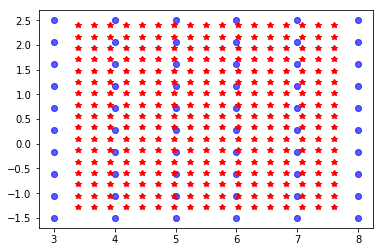

In [36]:
plot_mesh_in_latlon(src_lon_grid, src_lat_grid, phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(refinedGMlist[-1].x,refinedGMlist[-1].y , phi_color='r*', lam_color='r*')

### 3.1.2. Project source data (height) onto to the finest refined grid

#### Generate test topography

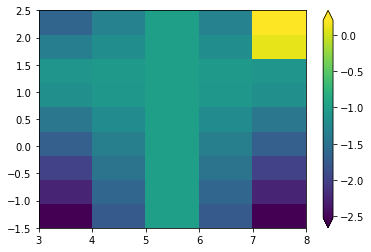

In [37]:
#Generate a fake source topography with a ridge in the middle
PI_180=np.pi/180
src_z = -1 - 1000*np.abs(np.sin((src_lon_grid-5) *PI_180) * np.sin((src_lat_grid-1.0) *PI_180))
#Add some positive height points as land
src_z[7:8,4] = 0.1
src_z[8:9,4:5] = 0.2
plt.pcolormesh(src_lon_grid,src_lat_grid,src_z); plt.colorbar(extend='both');


#### Project nearest neighbor

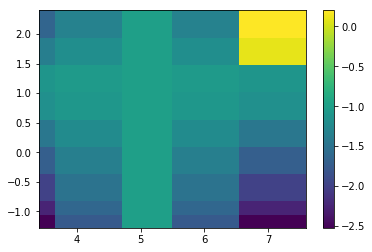

In [38]:
refinedGMlist[-1].project_source_data_onto_target_mesh(src_lon_grid,src_lat_grid,src_z)
plt.pcolormesh(refinedGMlist[-1].x,refinedGMlist[-1].y, refinedGMlist[-1].height); plt.colorbar();    

## 3.2. Initial thin wall parameters

For each fine target cell assign 4 thin walls with heights equal to the interpolated value above.

## Sand Box

## GEBCO dataset

In [8]:
!pip install netcdf4
import netCDF4

#gebcodata = netCDF4.Dataset('http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/MED_GEBCO_30sec.nc')
gebcodata = netCDF4.Dataset('MED_GEBCO_30sec.nc')
gebcodata

You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    title: The GEBCO_2014 Grid - a continuous terrain model for oceans and land at 30 arc-second intervals.
    institution: On behalf of the General Bathymetric Chart of the Oceans (GEBCO), the data are held at the British Oceanographic Data Centre (BODC).
    source: The bathymetric portion of the GEBCO_2014 Grid was largely developed from a database of ship track soundings with interpolation between soundings guided by satellite-derived gravity data. In areas where they improve on this existing base grid, data sets developed by other methods are included. Recognising the importance of local expertise when building a global bathymetric model, GEBCO have been working with regional mapping groups to improve the existing GEBCO grid. Details about the development of the grid and the data sets included can be found in the documentation that accompanies the data set. Wit

In [9]:
#for var in gebcodata.variables :  print(var,end=' ')
#lat lon elevation     
#Note that the variables are arrays but they are not numpy arrays. 
#Convert them to numpy using np.array so that they can be reshaped.
gebco_lon = np.array(gebcodata.variables['lon'])
gebco_lat = np.array(gebcodata.variables['lat'])
gebco_elv = np.array(gebcodata.variables['elevation'])
print('source grid array shapes: ' , gebco_lon.shape,gebco_lat.shape,gebco_elv.shape)
#source grid array shapes:  (6601,) (2162,) (2162, 6601)

source grid array shapes:  (6601,) (2162,) (2162, 6601)


In [11]:
gebco_lon_grd = np.tile(gebco_lon,(gebco_lat.shape[0],1))
gebco_lat_grd = np.tile(gebco_lat.reshape(gebco_lat.shape[0],1),(1,gebco_lon.shape[0]))
print('source grid array shapes: ' , gebco_lon_grd.shape,gebco_lat_grd.shape,gebco_elv.shape)
print('source grid nominal resolution : ',gebco_lon[-1]-gebco_lon[-2],gebco_lat[-1]-gebco_lat[-2] ) 
#source grid array shapes:  (2162, 6601) (2162, 6601) (2162, 6601)
#source grid nominal resolution :  0.00833333333333 0.00833333333333

source grid array shapes:  (2162, 6601) (2162, 6601) (2162, 6601)
source grid nominal resolution :  0.00833333333333 0.00833333333333


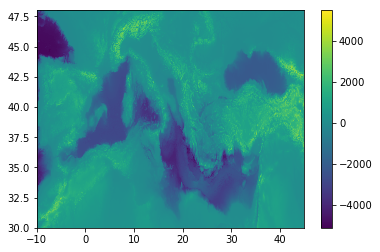

In [12]:
#plt.pcolormesh(gebco_lon_grd[:,:], gebco_lat_grd[:,:],gebco_elv[:,:]);plt.colorbar();

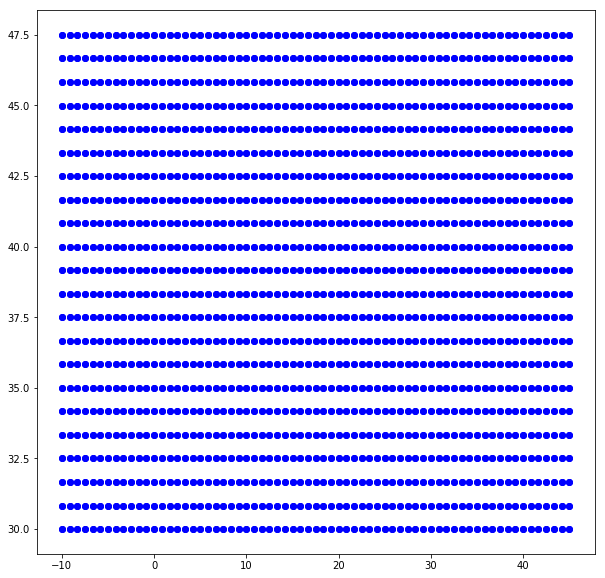

In [13]:
#Data arrays are too large to plot and my machine runs out of memory
plt.figure(figsize=(10,10))
plot_mesh_in_latlon(gebco_lon_grd[::100,::100], gebco_lat_grd[::100,::100], phi_color='bo', lam_color='bo')

In [53]:
print(gebco_lon_grd[0,0],gebco_lon_grd[-1,-1], gebco_lat_grd[0,0],gebco_lat_grd[-1,-1])
delxs= gebco_lon_grd[0,1]-gebco_lon_grd[0,0]
delys= gebco_lat_grd[1,0]-gebco_lat_grd[0,0]
print("delxs,delys: ", delxs,delys )
print((48.1-gebco_lat_grd[0,0])/delys)
print(gebco_lon_grd.shape[1],gebco_lat_grd.shape[0])

-9.99583333333 45.0041666667 29.9958333333 48.0041666667
delxs,delys:  0.00833333333333 0.00833333333333
2172.5
6601 2162


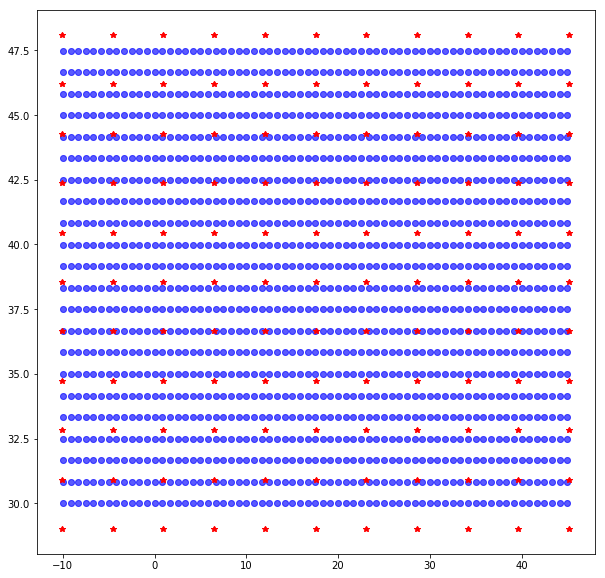

In [51]:
#test a target grid
plt.figure(figsize=(10,10))
trg2_lon_grid,trg2_lat_grid = generate_rect_test_grid(-10.1,45.2,1000,29.,48.1,1000)
plot_mesh_in_latlon(gebco_lon_grd[::100,::100], gebco_lat_grd[::100,::100], phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(trg2_lon_grid[::100,::100], trg2_lat_grid[::100,::100], phi_color='r*', lam_color='r*')

In [59]:
refinedGMlist_2,hits = refine_loop(trg2_lon_grid,trg2_lat_grid, gebco_lon_grd,gebco_lat_grd, max_stages=5)

Missed some! Must Refine! Stage  1 grid shape (1001, 1001)
Missed some! Must Refine! Stage  2 grid shape (2001, 2001)
Missed some! Must Refine! Stage  3 grid shape (4001, 4001)
Hit all! Done refining after  3  steps!


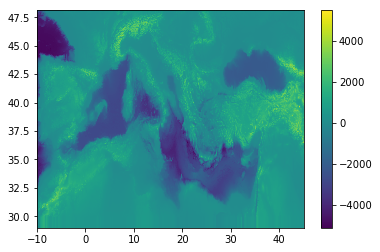

In [60]:
refinedGMlist_2[-1].project_source_data_onto_target_mesh(gebco_lon_grd,gebco_lat_grd,gebco_elv)
plt.pcolormesh(refinedGMlist_2[-1].x,refinedGMlist_2[-1].y, refinedGMlist_2[-1].height); plt.colorbar();    

In [23]:
#My workstation runs out of its 65G memory  and starts swapping towards a crash at Stage 6
#We cannot keep the list of meshes and have to free up memory!!!
#refinedGMlist_2 = refine_loop(trg2_lon_grid,trg2_lat_grid, gebco_lon_grd,gebco_lat_grd)
#Missed some! Must Refine! Stage  1 grid shape (1001, 1001)
#Missed some! Must Refine! Stage  2 grid shape (2001, 2001)
#Missed some! Must Refine! Stage  3 grid shape (4001, 4001)
#Missed some! Must Refine! Stage  4 grid shape (8001, 8001)
#Missed some! Must Refine! Stage  5 grid shape (16001, 16001)
#Missed some! Must Refine! Stage  6 grid shape (32001, 32001)
#There was a bug causing this!! 
#Nevertheless, this might be a real issue in higher resolution.

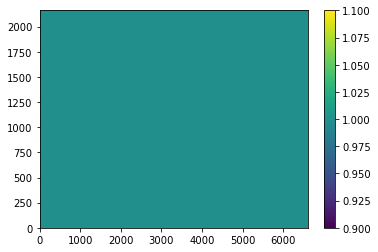

In [58]:
plt.pcolormesh(hits); plt.colorbar();

In [15]:
a = np.array([0.1, 0.5, 0.9, 1.1, 1.5])
np.floor(a+0.5)

array([ 0.,  1.,  1.,  1.,  2.])